# Generate the dataset
## We have 4 classes of 2D data points from each quadrant of the 2D plane
## We have an underltying functon that we would like top model, we do a symmetric sine function
## The dataset will have datapoints from each quadrant of the 2D plane sampled disproportionately
## The testing distributuion would be equivalent
## We will use 2 simple MLP's to model the function and the classifications


In [1]:
# All declarations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import WandbLogger
import wandb
from PIL import Image
import imageio
from io import BytesIO

In [2]:
# All global variables

TRAIN_CLASS_SEGMENTS = [0.7,0.1,0.1,0.1]
CLASS_NAMES = ['0','1','2','3']
CLASS_COLORS = ['red','green','blue','yellow']
NDIM = 2
NSAMPLES = 10000
NCLASSES = len(CLASS_NAMES)
RANGE = [-2,2]
TRAIN_TEST_SPLIT = 0.8


In [3]:
# Creating a simple MLP

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, output_size=1,softmax = False, sigmoid = False, tanh = False):
        super(MLP, self).__init__()

        if int(softmax) + int(sigmoid) + int(tanh) > 1:
            raise ValueError("Cannot have both sigmoid and softmax and tanh")
        
        self.num_layers = num_layers

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(input_size, hidden_size))
        for i in range(self.num_layers):
            self.layers.append(torch.nn.ReLU())
            self.layers.append(torch.nn.Linear(hidden_size, hidden_size))

        self.layers.append(torch.nn.ReLU())
        self.layers.append(torch.nn.Linear(hidden_size, output_size))
        # if softmax:
        #     self.layers.append(torch.nn.Softmax(dim=1))
        if sigmoid:
            self.layers.append(torch.nn.Sigmoid())
        if tanh:
            self.layers.append(torch.nn.Tanh())
        self.network = torch.nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.network(x)

In [4]:
#Generating data

x_data = np.random.random(size = (NSAMPLES,2)) * (RANGE[1] - RANGE[0]) + RANGE[0]
y_class = np.zeros((NSAMPLES,))


# Class 1
class1 = np.where(np.logical_and(x_data[:,0] > 0, x_data[:,1] > 0))[0]
y_class[class1] = 0

# Class 2
class2 = np.where(np.logical_and(x_data[:,0] < 0, x_data[:,1] > 0))[0]
y_class[class2] = 1

# Class 3
class3 = np.where(np.logical_and(x_data[:,0] < 0, x_data[:,1] < 0))[0]
y_class[class3] = 2

# Class 4
class4 = np.where(np.logical_and(x_data[:,0] > 0, x_data[:,1] < 0))[0]
y_class[class4] = 3

# Underlying function is a gaussian distribution
y_labels = np.exp(-0.03*np.sum(x_data**2, axis = 1))


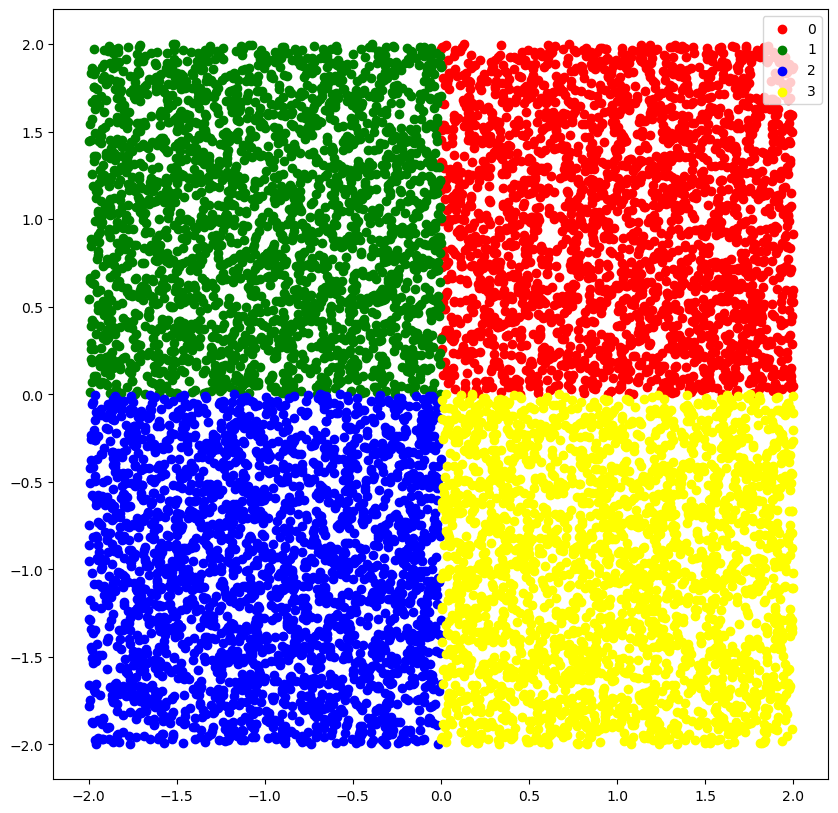

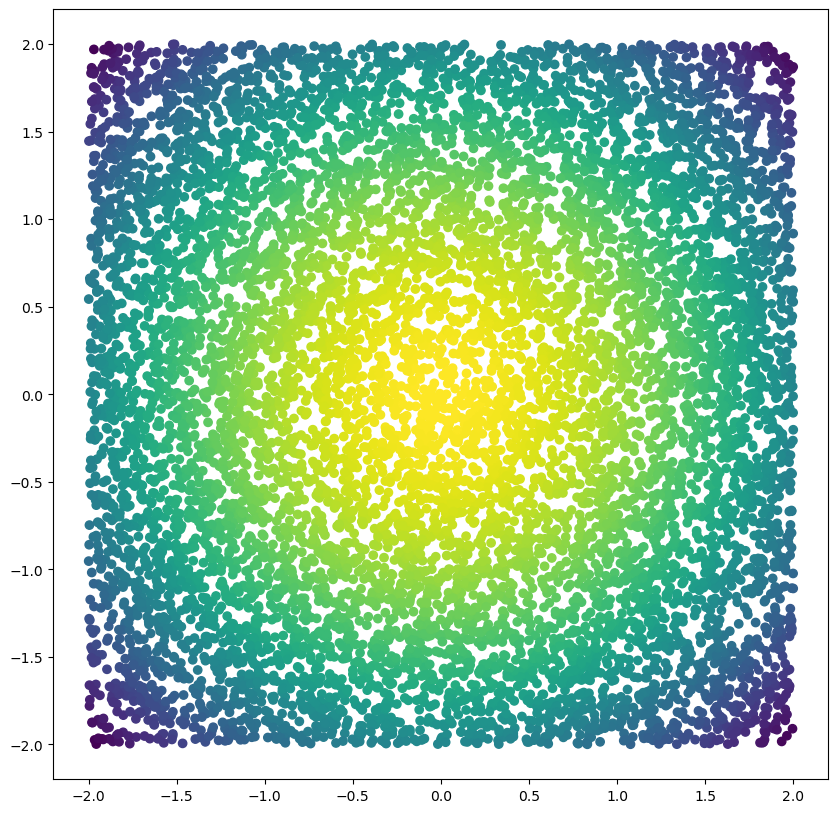

In [5]:
# Visualizing the data

plt.figure(figsize = (10,10))   
for i in range(NCLASSES):
    plt.scatter(x_data[y_class == i,0], x_data[y_class == i,1], c = CLASS_COLORS[i], label = CLASS_NAMES[i])
plt.legend()
plt.savefig('Dataclass.png')

# Visualizing the underlying function

plt.figure(figsize = (10,10))
plt.scatter(x_data[:,0], x_data[:,1], c = y_labels)
plt.savefig('Datafunc.png')

In [6]:
# Train test split 

train_test_split = int(TRAIN_TEST_SPLIT * NSAMPLES)
x_train, x_test = x_data[:train_test_split,:], x_data[train_test_split:,:]
y_class_train, y_class_test = y_class[:train_test_split], y_class[train_test_split:]
y_labels_train, y_labels_test = y_labels[:train_test_split], y_labels[train_test_split:]

# Creating the torch tensors

x_train = torch.tensor(x_train, dtype = torch.float32)
x_test = torch.tensor(x_test, dtype = torch.float32)
y_class_train = torch.tensor(y_class_train, dtype = torch.int64)
y_class_test = torch.tensor(y_class_test, dtype = torch.int64)
# Create one hot encoding for the class labels
# y_class_train = torch.nn.functional.one_hot(y_class_train, num_classes = NCLASSES).float()
# y_class_test = torch.nn.functional.one_hot(y_class_test, num_classes = NCLASSES).float()

y_labels_train = torch.tensor(y_labels_train, dtype = torch.float32)
y_labels_test = torch.tensor(y_labels_test, dtype = torch.float32)

print(x_train.shape, x_test.shape, y_class_train.shape, y_class_test.shape, y_labels_train.shape, y_labels_test.shape)

# Create the training and validation dataloaders from the torch tensors

train_dataset = torch.utils.data.TensorDataset(x_train, y_class_train,y_labels_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

val_dataset = torch.utils.data.TensorDataset(x_test, y_class_test,y_labels_test)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle = True)

torch.Size([8000, 2]) torch.Size([2000, 2]) torch.Size([8000]) torch.Size([2000]) torch.Size([8000]) torch.Size([2000])


In [7]:
# Pytorch lightning module to train the models
#impor trace

from pdb import set_trace

class classTrainer(pl.LightningModule):

    # Declare the class models and the function models
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.model = MLP(input_size, hidden_size, output_size = output_size, num_layers = 3, softmax = True)
        self.func_model = MLP(input_size, hidden_size, output_size = 1, num_layers =3)
        self.loss = torch.nn.CrossEntropyLoss()
        self.funv_loss = torch.nn.MSELoss()
    
    def forward(self, x):
        return (self.model(x), self.func_model(x))
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y_class, y_labels = batch
        y_pred_class, y_pred_labels = self.forward(x)
        # print(y_pred_class.shape, y_class.shape)
        # print(y_pred_class[0])
        loss_class = self.loss(y_pred_class, y_class)
        
        loss_func = self.funv_loss(y_pred_labels, y_labels.unsqueeze(1))
        loss = loss_class + loss_func
        self.log('train_loss_class', loss_class.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_loss_func', loss_func.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y_class, y_labels = batch
        y_pred_class, y_pred_labels = self.forward(x)
        loss_class = self.loss(y_pred_class, y_class)
        loss_func = self.funv_loss(y_pred_labels, y_labels.unsqueeze(1))
        loss = loss_class + loss_func
        self.log('val_loss_class', loss_class.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_loss_func', loss_func.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def return_model_weights(self):
        return [self.model.state_dict(), self.func_model.state_dict()] 







In [8]:
# Training the model
model = classTrainer(input_size=2,
                       hidden_size=128,
                        output_size=4)
logger = TensorBoardLogger("tb_logs", name="class")
wandb.finish()
wandb_logger = WandbLogger(project='lang-dataaugment', log_model='all')

trainer = pl.Trainer(max_epochs=100, devices=1, accelerator='gpu',logger=[logger,wandb_logger])
wandb_logger.watch(model, log='all')
trainer.fit(model, train_loader, val_loader)

# Saving the lightning module
torch.save(model.state_dict(), 'classmodel.pt')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: harshg5799. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name       | Type             | Params
------------------------------------------------
0 | model      | MLP              | 50.4 K
1 | func_model | MLP              | 50.0 K
2 | loss       | CrossEntropyLoss | 0     
3 | funv_loss  | MSELoss          | 0     
------------------------------------------------
100 K     Trainable params
0         Non-trainable para

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 99: 100%|██████████| 250/250 [00:03<00:00, 80.46it/s, v_num=1d7s, train_loss_class_step=0.000677, train_loss_func_step=4.74e-6, val_loss_class_step=1.07e-6, val_loss_func_step=1.88e-5, val_loss_class_epoch=0.0109, val_loss_func_epoch=1.21e-5, train_loss_class_epoch=0.00994, train_loss_func_epoch=3.49e-6]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 250/250 [00:03<00:00, 76.98it/s, v_num=1d7s, train_loss_class_step=0.000677, train_loss_func_step=4.74e-6, val_loss_class_step=1.07e-6, val_loss_func_step=1.88e-5, val_loss_class_epoch=0.0109, val_loss_func_epoch=1.21e-5, train_loss_class_epoch=0.00994, train_loss_func_epoch=3.49e-6]


In [9]:
# Learning the augmentation network
# Objective is simple, we take an desired input class and learn a neural network to augment data to the desired class
# Need to figure out the generqative prcoess in altent diffusioin, is the addition step a proabbailitic step or something more complex

class augmentTrainer(pl.LightningModule):

    # Declare the class models and the function models
    def __init__(self, input_size, hidden_size, output_size, class_modelweights = None, func_modelweights = None, T = 5):
        super().__init__()
        self.augment_model = MLP(input_size + NCLASSES, hidden_size, output_size = input_size, num_layers = 3, tanh = True)
        self.class_model = MLP(input_size, hidden_size, output_size = NCLASSES, num_layers = 3, softmax = True)
        self.class_model.load_state_dict(class_modelweights)
        self.class_model.requires_grad_(False)
        self.func_model = MLP(input_size, hidden_size, output_size = 1, num_layers =3)
        self.func_model.load_state_dict(func_modelweights)
        self.func_model.requires_grad_(False)
        self.T = 5 

        self.loss = torch.nn.CrossEntropyLoss()
    
    def forward(self, x,target_class):
        x_ = x.clone()
        #one hot target class'

        print(target_class.shape, target_class.type())
        target_class = torch.nn.functional.one_hot(target_class,
                                                    num_classes = NCLASSES).type(torch.float32)
        input = torch.cat((x_, target_class), dim = 1)
        for j in range(self.T):
            x_ = x_ + self.augment_model(input)
            input = torch.cat((x_, target_class),dim=1)

        return x_
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y_class, y_labels = batch
        
        x_mod = self.forward(x,y_class)
        y_pred_class = self.class_model(x_mod)
        loss_class = self.loss(y_pred_class, y_class)
        self.log('train_loss_class', loss_class.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss_class
    
    def validation_step(self, batch, batch_idx):
        x, y_class, y_labels = batch
        y_pred_class = self.class_model(self.forward(x,y_class))
        loss_class = self.loss(y_pred_class, y_class)
        self.log('val_loss_class', loss_class.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss_class

    def return_model_weights(self):
        return self.augment_model.state_dict()




In [10]:
# Creating the modified dataset for the augmentation network, we take the original dataset and permute the class labels with it

x_train_aug = torch.repeat_interleave(x_train, NCLASSES, dim = 0)
x_test_aug = torch.repeat_interleave(x_test, NCLASSES, dim = 0)
y_train_class_aug = torch.cat([torch.tensor(np.zeros(y_class_train.shape[0]) + i) for i in range(NCLASSES)],
                              dim = 0).type(torch.LongTensor)
y_train_labels_aug = torch.repeat_interleave(y_labels_train, NCLASSES, dim = 0)
y_test_class_aug = torch.cat([torch.tensor(np.zeros(y_class_test.shape[0]) + i) for i in range(NCLASSES)]
                             ,dim = 0).type(torch.LongTensor)
y_test_labels_aug = torch.repeat_interleave(y_labels_test, NCLASSES, dim = 0)

print("Dataset Shapes:")
print(x_train_aug.shape, y_train_class_aug.shape, y_train_labels_aug.shape)
print(x_test_aug.shape, y_test_class_aug.shape, y_test_labels_aug.shape)

# Creating the dataloaders and the dataset
train_dataset_aug = torch.utils.data.TensorDataset(x_train_aug, y_train_class_aug, y_train_labels_aug)
train_loader_aug = torch.utils.data.DataLoader(train_dataset_aug, batch_size=2048, shuffle=True)
val_dataset_aug = torch.utils.data.TensorDataset(x_test_aug, y_test_class_aug, y_test_labels_aug)
val_loader_aug = torch.utils.data.DataLoader(val_dataset_aug, batch_size=2048, shuffle=True)

# Training the model

#Load the class and func model trained weights

model = classTrainer(input_size=2,
                    hidden_size=128,
                    output_size=4)

model.load_state_dict(torch.load('classmodel.pt'))
T = 3
aug_model = augmentTrainer(input_size=2,hidden_size=128,output_size=4, 
                       class_modelweights = model.return_model_weights()[0], 
                       func_modelweights = model.return_model_weights()[1],
                       T = T)

logger = TensorBoardLogger("tb_logs", name="augment")
wandb.finish()
wandb_logger = WandbLogger(project='lang-dataaugment', log_model='all')

trainer = pl.Trainer(max_epochs=100, devices=1, accelerator='gpu',logger=[logger,wandb_logger])
wandb_logger.watch(aug_model, log='all')
trainer.fit(aug_model, train_loader_aug, val_loader_aug)

# Save the lightning module
torch.save(aug_model.state_dict(), 'augmodel_T{}.pt'.format(T))

Dataset Shapes:
torch.Size([32000, 2]) torch.Size([32000]) torch.Size([32000])
torch.Size([8000, 2]) torch.Size([8000]) torch.Size([8000])


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_class_epoch,█▃▃▂▃▂▂▂▂▂▂▂▁▃▂▂▁▁▃▂▁▂▃▁▁▁▂▂▁▂▂▂▁▁▂▁▁▁▂▁
train_loss_class_step,▃█▁▅▁▄▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁
train_loss_func_epoch,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_func_step,▃▁▁▁▁▃▂█▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂▁▂▁▁
trainer/global_step,▁▁▁▁▁▁▁▁▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▇▃▃▃█▃▃▃▃▃▃▃▃▃▃
val_loss_class_epoch,▆▄▂▃▂▂▂▂▂▂▁▃▁▁▃▁▆▁▄▂▁▁▂▂▁▁▂▂▂▁█▂▂▁▂▁▁▁▂▁
val_loss_class_step,▁▁▁█▃▁▁▁▁▁▂▁▁▁▁▁▂▁▅▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▃▁▁▁▂
val_loss_func_epoch,▂▁▁▁▁▅▄▁▃▄▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▇▁▁▁▁▁▁▁▂▁
val_loss_func_step,▂▁▁▂▁▁▅▂▂▂▁▂▁█▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▇▁▁▁▁▁▁▁▂▂
epoch,99


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name          | Type             | Params
---------------------------------------------------
0 | augment_model | MLP              | 50.7 K
1 | class_model   | MLP              | 50.4 K
2 | func_model    | MLP              | 50.0 K
3 | loss          | CrossEntropyLoss | 0     
---------------------------------------------------
50.7 K    Trainable params
100 K     Non-trainable params
151 K     Total params
0.605     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 84.56it/s]torch.Size([2048]) torch.cuda.LongTensor
                                                                           

/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/hg22723/anaconda3/envs/torch-2.0/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wo

Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 25.41it/s, v_num=i513, train_loss_class_step=6.180]torch.Size([2048]) torch.cuda.LongTensor
torch.Size([2048]) torch.cuda.LongTensor
torch.Size([2048]) torch.cuda.LongTensor
torch.Size([1856]) torch.cuda.LongTensor
Epoch 1: 100%|██████████| 16/16 [00:00<00:00, 25.78it/s, v_num=i513, train_loss_class_step=15.80, val_loss_class_step=4.050, val_loss_class_epoch=4.180, train_loss_class_epoch=33.20]torch.Size([2048]) torch.cuda.LongTensor
torch.Size([2048]) torch.cuda.LongTensor
torch.Size([2048]) torch.cuda.LongTensor
torch.Size([1856]) torch.cuda.LongTensor
Epoch 2: 100%|██████████| 16/16 [00:00<00:00, 24.37it/s, v_num=i513, train_loss_class_step=15.60, val_loss_class_step=16.40, val_loss_class_epoch=16.40, train_loss_class_epoch=13.40]torch.Size([2048]) torch.cuda.LongTensor
torch.Size([2048]) torch.cuda.LongTensor
torch.Size([2048]) torch.cuda.LongTensor
torch.Size([1856]) torch.cuda.LongTensor
Epoch 3: 100%|██████████| 16/16 [00:00<00:00, 2

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 16/16 [00:01<00:00,  9.87it/s, v_num=i513, train_loss_class_step=0.641, val_loss_class_step=0.737, val_loss_class_epoch=0.772, train_loss_class_epoch=0.713]


In [11]:
# Visualization of the augmentations on the training data

#Load the model and the augmented model
T = 3
aug_model = augmentTrainer(input_size=2,hidden_size=128,output_size=4, 
                       class_modelweights = model.return_model_weights()[0], 
                       func_modelweights = model.return_model_weights()[1],
                       T = T)
aug_model.load_state_dict(torch.load('augmodel.pt'))

augment_model = MLP(2 + NCLASSES, 128, output_size = 2, num_layers = 3, tanh = True)
augment_model.load_state_dict(aug_model.return_model_weights())

# Take the same samples from the training dataset and visualize the augmentations

x_vis_train_data = [x_train[np.where(y_class_train == 0)[0][:100]], 
                    x_train[np.where(y_class_train == 1)[0][:100]],
                    x_train[np.where(y_class_train == 2)[0][:100]],
                    x_train[np.where(y_class_train == 3)[0][:100]]]


for ds_j,ds in enumerate(x_vis_train_data):
    frames = []

    target_class = np.concatenate([(np.zeros(ds.shape[0]) + j) for j in range(NCLASSES)],axis=0)
    target_class = torch.tensor(target_class).type(torch.LongTensor)

    x = torch.repeat_interleave(torch.tensor(ds, dtype = torch.float32), NCLASSES, dim = 0)

    target_class_onehot = torch.nn.functional.one_hot(target_class, num_classes = NCLASSES)
    input = torch.cat((x, target_class_onehot), dim = 1)
    augment_list = [x.cpu().detach().numpy()]
    for j in range(T):
        augment = augment_model(input)
        x = x + augment
        augment_list.append(x.cpu().detach().numpy())
    
    frames = []
    for j,aug in enumerate(augment_list):
        # Split the augmented data per the target class for plotting
        aug_split = np.split(aug, NCLASSES, axis = 0)
        fig, axs = plt.subplots(1, NCLASSES, figsize=(16, 4))
        # set the axis limits to range
        for i in range(NCLASSES):
            axs[i].set_xlim([RANGE[0], RANGE[1]])
            axs[i].set_ylim([RANGE[0],RANGE[1]])  


        if j ==0:
            color = 'blue'
        else:
            color = 'red'
        for i in range(NCLASSES):
            axs[i].scatter(aug_split[i][:, 0], aug_split[i][:, 1], s = 1, color = color)
            axs[i].set_title(f'Data Moves to target Class {i}')
        buf = BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        im = Image.open(buf)
        frames.append(np.array(im))
        buf.close()

    import os
    if not os.path.exists('results_T{}'.format(T)):
        os.makedirs('results_T{}'.format(T))
    # Create the GIF
    imageio.mimsave('results_T{}/animated{}.gif'.format(T,ds_j), frames, duration=5.0, loop = 0)



/tmp/ipykernel_1353204/2351223166.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.repeat_interleave(torch.tensor(ds, dtype = torch.float32), NCLASSES, dim = 0)
